In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm import tqdm
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from scipy.ndimage import gaussian_filter
import random
from torchmetrics.classification import MulticlassAccuracy, MulticlassJaccardIndex, MulticlassStatScores
from collections import Counter
"""
from google.colab import drive
drive.mount('/content/drive')"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')"

In [3]:
def plot_label_distribution(dataset):
    label_counts = Counter()
    for _, mask in dataset:
        labels, counts = np.unique(mask.numpy(), return_counts=True)
        label_counts.update(dict(zip(labels, counts)))

    # Sorting by class index
    sorted_labels = sorted(label_counts.keys())
    counts = [label_counts[l] for l in sorted_labels]

    plt.figure(figsize=(8, 5))
    plt.bar(sorted_labels, counts, tick_label=[f'Class {i}' for i in sorted_labels])
    plt.xlabel('Class')
    plt.ylabel('Pixel Count')
    plt.title('Label Distribution (Pixel-wise)')
    plt.grid(True)
    plt.show()

In [4]:
"""class LandUseDataset(torch.utils.data.Dataset):
    def __init__(self, path, transform=None):
        data = np.load(path)
        self.X = np.clip(data['X'] / 10000.0, 0.0, 1.0)   # Shape: (N, C=13, H, W)
        self.y = data['y']   # Shape: (N, H, W)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)  # (C=13, H, W)
        y = torch.tensor(self.y[idx], dtype=torch.long)     # (H, W)

        if self.transform:
            X = self.transform(X)

        return X, y
"""

class LandUseDataset(torch.utils.data.Dataset):
    def __init__(self, path, transform=None):
        data = np.load(path)
        self.X = np.clip(data['X'] / 10000.0, 0.0, 1.0)   # Shape: (N, C=13, H, W)
        self.y = self._remap_labels(data['y'])            # Shape: (N, H, W)
        self.transform = transform

    def _remap_labels(self, y):
        id2idx = {10: 0, 20: 1, 30: 2, 40: 3, 50: 4, 60: 5, 80: 6, 90: 7}
        y_remapped = np.copy(y)
        for old, new in id2idx.items():
            y_remapped[y == old] = new
        return y_remapped

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)  # (C=13, H, W)
        y = torch.tensor(self.y[idx], dtype=torch.long)     # (H, W)

        if self.transform:
            X = self.transform(X)

        return X, y

In [5]:
class UNetResNet18(nn.Module):
    def __init__(self, num_classes, input_channels=13):
        super(UNetResNet18, self).__init__()

        # Load pretrained ResNet18
        resnet = models.resnet18(pretrained=True)

        # Override the first conv layer to accept 13 input channels
        self.encoder_conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder_bn1 = resnet.bn1
        self.encoder_relu = resnet.relu
        self.encoder_maxpool = resnet.maxpool

        # ResNet layers
        self.encoder_layer1 = resnet.layer1  # 64 -> 64
        self.encoder_layer2 = resnet.layer2  # 64 -> 128
        self.encoder_layer3 = resnet.layer3  # 128 -> 256
        self.encoder_layer4 = resnet.layer4  # 256 -> 512

        # Decoder part (upsampling + skip connections)
        self.upconv4 = self._upsample(512, 256)
        self.upconv3 = self._upsample(256 + 256, 128)  # skip conn
        self.upconv2 = self._upsample(128 + 128, 64)   # skip conn
        self.upconv1 = self._upsample(64 + 64, 64)

        # Final classifier
        self.classifier = nn.Conv2d(64, num_classes, kernel_size=1)

    def _upsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder_relu(self.encoder_bn1(self.encoder_conv1(x)))  # [B, 64, H/2, W/2]
        x2 = self.encoder_layer1(self.encoder_maxpool(x1))               # [B, 64, H/4, W/4]
        x3 = self.encoder_layer2(x2)                                     # [B, 128, H/8, W/8]
        x4 = self.encoder_layer3(x3)                                     # [B, 256, H/16, W/16]
        x5 = self.encoder_layer4(x4)                                     # [B, 512, H/32, W/32]

        # Decoder with U-Net style skip connections (at least 2 used: x4, x3)
        d4 = self.upconv4(x5)                    # [B, 256, H/16, W/16]
        d4 = torch.cat([d4, x4], dim=1)          # skip conn 1

        d3 = self.upconv3(d4)                    # [B, 128, H/8, W/8]
        d3 = torch.cat([d3, x3], dim=1)          # skip conn 2

        d2 = self.upconv2(d3)                    # [B, 64, H/4, W/4]
        d2 = torch.cat([d2, x2], dim=1)          # optional skip

        d1 = self.upconv1(d2)                    # [B, 64, H/2, W/2]

        out = F.interpolate(d1, scale_factor=2, mode='bilinear', align_corners=False)
        out = self.classifier(out)

        return out


In [6]:
class UNetResNet50(nn.Module):
    def __init__(self, num_classes, input_channels=13):
        super(UNetResNet50, self).__init__()

        # Load pretrained ResNet-50
        resnet = models.resnet50(pretrained=True)

        # Replace the first conv layer to accept 13 input channels
        self.encoder_conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder_bn1 = resnet.bn1
        self.encoder_relu = resnet.relu
        self.encoder_maxpool = resnet.maxpool

        # ResNet-50 layers
        self.encoder_layer1 = resnet.layer1  # 256
        self.encoder_layer2 = resnet.layer2  # 512
        self.encoder_layer3 = resnet.layer3  # 1024
        self.encoder_layer4 = resnet.layer4  # 2048

        # Decoder
        self.upconv4 = self._upsample(2048, 1024)
        self.upconv3 = self._upsample(1024 + 1024, 512)
        self.upconv2 = self._upsample(512 + 512, 256)
        self.upconv1 = self._upsample(256 + 256, 64)

        self.classifier = nn.Conv2d(64, num_classes, kernel_size=1)

    def _upsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder_relu(self.encoder_bn1(self.encoder_conv1(x)))  # [B, 64, H/2, W/2]
        x2 = self.encoder_layer1(self.encoder_maxpool(x1))               # [B, 256, H/4, W/4]
        x3 = self.encoder_layer2(x2)                                     # [B, 512, H/8, W/8]
        x4 = self.encoder_layer3(x3)                                     # [B, 1024, H/16, W/16]
        x5 = self.encoder_layer4(x4)                                     # [B, 2048, H/32, W/32]

        # Decoder with skip connections
        d4 = self.upconv4(x5)                    # [B, 1024, H/16, W/16]
        d4 = torch.cat([d4, x4], dim=1)

        d3 = self.upconv3(d4)                    # [B, 512, H/8, W/8]
        d3 = torch.cat([d3, x3], dim=1)

        d2 = self.upconv2(d3)                    # [B, 256, H/4, W/4]
        d2 = torch.cat([d2, x2], dim=1)

        d1 = self.upconv1(d2)                    # [B, 64, H/2, W/2]

        out = F.interpolate(d1, scale_factor=2, mode='bilinear', align_corners=False)
        out = self.classifier(out)

        return out


In [7]:
def train_one_epoch(model, optimizer, train_dl, device, criterion):
    model.train()
    curr_loss = 0.
    for X, y in train_dl:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        curr_loss += loss.item()
    return curr_loss / len(train_dl)

"""def validate(model, val_dl, device, criterion):
    model.eval()
    curr_loss = 0.
    with torch.inference_mode():
        for X, y in val_dl:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)
            curr_loss += loss.item()
    return curr_loss / len(val_dl)"""

def validate(model, val_dl, device, criterion, num_classes):
    model.eval()
    curr_loss = 0.

    # Metrics
    pixel_acc = MulticlassAccuracy(num_classes=num_classes, average='micro').to(device)
    iou = MulticlassJaccardIndex(num_classes=num_classes, average=None).to(device)  # per-class IoU
    mean_iou = MulticlassJaccardIndex(num_classes=num_classes, average='macro').to(device)  # mean IoU
    stat_scores = MulticlassStatScores(num_classes=num_classes, average=None).to(device)
    stat_scores.reset()
    pixel_acc.reset()
    iou.reset()
    mean_iou.reset()

    with torch.inference_mode():
        for X, y in val_dl:
            X, y = X.to(device), y.to(device)

            logits = model(X)  # shape: [B, C, H, W]
            loss = criterion(logits, y)
            curr_loss += loss.item()

            preds = torch.argmax(logits, dim=1)  # shape: [B, H, W]

            preds_flat = preds.flatten()
            y_flat = y.flatten()

            # Update metrics
            pixel_acc.update(preds_flat, y_flat)
            iou.update(preds_flat, y_flat)
            mean_iou.update(preds_flat, y_flat)
            stat_scores.update(preds_flat, y_flat)


    # Compute final metric values
    avg_loss = curr_loss / len(val_dl)
    pixel_accuracy = pixel_acc.compute().item()
    per_class_iou = iou.compute().cpu().numpy()  # shape: [num_classes]
    mean_iou_val = mean_iou.compute().item()
    stat_result = stat_scores.compute()  # shape: [num_classes, 4]
    per_class_support = stat_result[:, 0] + stat_result[:, 2]  # TP + FN
    # Normalize support to get weights
    weights = per_class_support.float() / per_class_support.sum()
    # Compute weighted mean IoU
    weighted_mean_iou = (weights * torch.tensor(per_class_iou).to(device)).sum().item()

    return {
        "val_loss": avg_loss,
        "pixel_accuracy": pixel_accuracy,
        "mean_iou": mean_iou_val,
        "per_class_iou": per_class_iou,
        "weighted_mean_iou": weighted_mean_iou
    }


In [8]:
class RandomApplyTransform:
    def __init__(self, transform, p=0.5):
        self.transform = transform
        self.p = p

    def __call__(self, x):
        if random.random() < self.p:
            return self.transform(x)
        return x

class RandomRotationTensor:
    def __init__(self, degrees=15):
        self.degrees = degrees

    def __call__(self, x):
        angle = random.uniform(-self.degrees, self.degrees)
        return TF.rotate(x, angle)

class RandomRadiometricShift:
    def __init__(self, scale=0.05):
        self.scale = scale

    def __call__(self, x):
        shift = torch.empty_like(x).uniform_(-self.scale, self.scale)
        return x + shift

class RandomGaussianBlur:
    def __init__(self, sigma_range=(0.5, 1.0)):
        self.sigma_range = sigma_range

    def __call__(self, x):
        sigma = random.uniform(*self.sigma_range)
        x_np = x.numpy()
        x_np = gaussian_filter(x_np, sigma=(0, 1, 1))  # blur spatial dims
        return torch.from_numpy(x_np)


In [9]:
def get_dataloaders(path, batch_size=16, train_split=0.7, val_split=0.15, test_split=0.15, seed=42):
    """
    Creates and returns dataloaders for training, validation, and testing.

    Args:
        path (str): Path to the .npz file containing the dataset
        batch_size (int): Batch size for the dataloaders
        train_split (float): Proportion of data to use for training
        val_split (float): Proportion of data to use for validation
        test_split (float): Proportion of data to use for testing
        seed (int): Random seed for reproducibility

    Returns:
        tuple: (dataset, train_loader, val_loader, test_loader)
    """
    # Define transforms for training
    train_transform = T.Compose([
        T.RandomHorizontalFlip(p=0.4),
        #RandomApplyTransform(RandomRotationTensor(degrees=15), p=0.5),
        RandomApplyTransform(RandomRadiometricShift(scale=0.05), p=0.4),
        #RandomApplyTransform(RandomGaussianBlur(), p=0.2)
    ])

    # Create a single dataset instance
    dataset = LandUseDataset(path)

    # Split indices manually for reproducibility
    total_size = len(dataset)
    train_size = int(train_split * total_size)

    indices = list(range(total_size))
    random.seed(seed)
    random.shuffle(indices)

    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    # Create custom dataset wrappers that apply transforms on-the-fly
    class TransformSubset(torch.utils.data.Dataset):
        def __init__(self, dataset, indices, transform=None):
            self.dataset = dataset
            self.indices = indices
            self.transform = transform

        def __len__(self):
            return len(self.indices)

        def __getitem__(self, idx):
            X, y = self.dataset[self.indices[idx]]
            if self.transform:
                X = self.transform(X)
            return X, y

    # Create subsets with appropriate transforms
    train_ds = TransformSubset(dataset, train_indices, transform=train_transform)
    val_ds = TransformSubset(dataset, val_indices, transform=None)

    # Create dataloaders
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    return dataset, train_loader, val_loader

Unique labels in masks: [0 1 2 3 4 5 6 7]


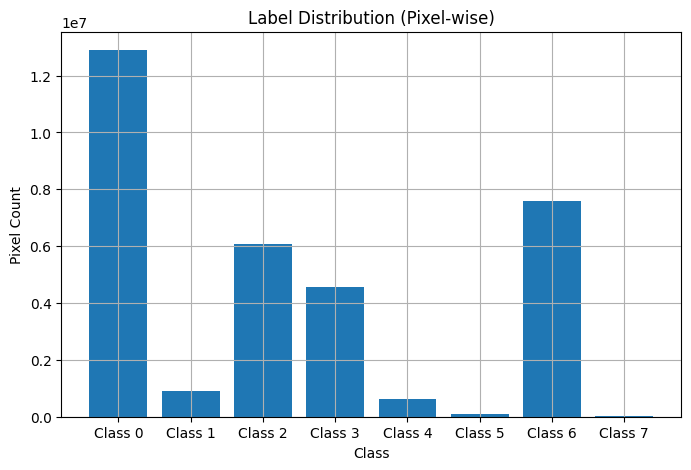

In [10]:
#dataset, train_loader, val_loader = get_dataloaders("/content/drive/MyDrive/image_label_dataset.npz")
#dataset, train_loader, val_loader = get_dataloaders("/content/drive/MyDrive/generated_dataset.npz")
dataset, train_loader, val_loader = get_dataloaders("generated_dataset.npz")
num_classes = len(np.unique(dataset.y))
print("Unique labels in masks:", np.unique(dataset.y))
plot_label_distribution(dataset)

In [11]:
# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [12]:
def train_model(model, num_epochs, device, train_loader, val_loader, num_classes, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    model.to(device)

    best_val_loss = 10000.
    metrics = {"train_losses": [], "val_losses": [], "pixel_accs": [], "mean_ious": [], "per_class_ious": [], "weighted_ious": []}
    for epoch in range(num_epochs):
        avg_train_loss = train_one_epoch(model, optimizer, train_loader, device, criterion)
        val_metrics = validate(model, val_loader, device, criterion, num_classes)
        print(f"\nEpoch {epoch + 1}")
        print(f"Average Training Loss {avg_train_loss}")
        for metric, value in val_metrics.items():
            print(f"{metric}: {value}")
        scheduler.step(val_metrics["val_loss"])

        if val_metrics["val_loss"] < best_val_loss:
            best_val_loss = val_metrics["val_loss"]
            torch.save(model.state_dict(), f"best_model_lr_{learning_rate}.pt")
            print("Saved new best model.")

        metrics["train_losses"].append(avg_train_loss)
        metrics["val_losses"].append(val_metrics["val_loss"])
        metrics["pixel_accs"].append(val_metrics["pixel_accuracy"])
        metrics["mean_ious"].append(val_metrics["mean_iou"])
        metrics["per_class_ious"].append(val_metrics["per_class_iou"])
        metrics["weighted_ious"].append(val_metrics["weighted_mean_iou"])


    print(f"\nBest model was with(val loss = {best_val_loss:.4f})")
    return metrics, best_val_loss


In [1]:
model = UNetResNet18(input_channels=13, num_classes=num_classes)
metrics, _ = train_model(model, 50, device, train_loader, val_loader, num_classes, learning_rate=0.0001)

NameError: name 'UNetResNet18' is not defined

In [13]:
model = UNetResNet50(input_channels=13, num_classes=num_classes)

train_model(model, 50, device, train_loader, val_loader, num_classes, learning_rate=0.0001)

/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/alex/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 37.6MB/s]
/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is depr


Epoch 1
Average Training Loss 1.1997914937409488
val_loss: 0.8258086560588134
pixel_accuracy: 0.7572780251502991
mean_iou: 0.31701070070266724
per_class_iou: [0.7100302  0.         0.40318972 0.43122652 0.         0.
 0.99163926 0.        ]
Saved new best model.

Epoch 2
Average Training Loss 0.8832721385088834
val_loss: 0.6952615599883231
pixel_accuracy: 0.780823290348053
mean_iou: 0.32200682163238525
per_class_iou: [0.77413034 0.         0.33632106 0.47271836 0.         0.
 0.992885   0.        ]
Saved new best model.

Epoch 3
Average Training Loss 0.78464034978639
val_loss: 0.6272250531535399
pixel_accuracy: 0.7928830981254578
mean_iou: 0.3268784284591675
per_class_iou: [0.76401025 0.         0.43602052 0.42296118 0.         0.
 0.9920353  0.        ]
Saved new best model.

Epoch 4
Average Training Loss 0.7527399330653928
val_loss: 0.5746113352085415
pixel_accuracy: 0.8165193796157837
mean_iou: 0.3496816158294678
per_class_iou: [7.8519267e-01 0.0000000e+00 4.7579324e-01 5.4589009e-

KeyboardInterrupt: 

In [ ]:
"""learning_rates = [1e-3, 5e-4, 1e-4]
best_val_losses = []
for lr in learning_rates:
    print(f"\nRunning experiment with initial learning rate = {lr}")
    metrics, best_val_loss = train_model(model, num_epochs, device, train_loader, val_loader, num_classes, learning_rate)
"""

'learning_rates = [1e-3, 5e-4, 1e-4]\nbest_val_loss = float(\'inf\')\nbest_model_state = None\nbest_lr = None\n\nfor lr in learning_rates:\n    print(f"\nRunning experiment with learning rate = {lr}")\n\n    model = UNetResNet18(input_channels=13, num_classes=int(dataset.y.max()) + 1).to(device)\n    optimizer = optim.Adam(model.parameters(), lr=lr)\n    criterion = nn.CrossEntropyLoss()\n    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=\'min\', factor=0.5, patience=3, verbose=True)\n\n    num_epochs = 30\n\n    for epoch in range(num_epochs):\n        train_loss = train_one_epoch(model, optimizer, train_loader, device, criterion)\n        val_loss = validate(model, val_loader, device, criterion)\n        print(f"Epoch {epoch + 1}:\n\tAverage Training Loss: {train_loss:.4f}\n\tAverage Validation Loss: {val_loss:.4f}")\n        scheduler.step(val_loss)\n\n        if val_loss < best_val_loss:\n            best_val_loss = val_loss\n            best_lr = lr\n           